# Imports

In [13]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
import shap

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

# Modeling codes

In [14]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

In [15]:
## Load the joblib file stored in the models folder
fname = "E:\Git Hub\Repository\Prediction-of-Product-Sales\Data/prediction_sales.joblib"
loaded = joblib.load(fname)

# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [27]:
## Saving the loaded objects as separate varaibles
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

In [28]:
X_train.head()

Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  \
512         5.695          Low Fat         0.065857           Frozen Foods   
330        20.700          Low Fat         0.092613                  Dairy   
5307       19.750          Low Fat         0.012438  Fruits and Vegetables   
6689        5.730          Low Fat         0.045557            Soft Drinks   
3024       17.850          Low Fat         0.018052     Health and Hygiene   

      Item_MRP  Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
512   258.5646                       2009      Medium               Tier 3   
330    76.3670                       1987        High               Tier 3   
5307  189.9872                       1987        High               Tier 3   
6689   85.3882                       2009      Medium               Tier 3   
3024   96.6094                       1999      Medium               Tier 1   

            Outlet_Type  
512   Supermarket Type2  
330   Supermarket Type1  
5307  Supermarket Type1  
6689  Supermarket Type2  
3024  Supermarket Type1

In [29]:
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         index=X_train.index,
                          columns=feature_names)
x_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        index=X_test.index,
                        columns=feature_names)
X_train_df.head()

X does not have valid feature names, but OrdinalEncoder was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but OrdinalEncoder was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names


Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
512         5.695         0.065857  258.5646                     2009.0   
330        20.700         0.092613   76.3670                     1987.0   
5307       19.750         0.012438  189.9872                     1987.0   
6689        5.730         0.045557   85.3882                     2009.0   
3024       17.850         0.018052   96.6094                     1999.0   

      Outlet_Size  Outlet_Location_Type  Item_Fat_Content_Low Fat  \
512           1.0                   2.0                       1.0   
330           2.0                   2.0                       1.0   
5307          2.0                   2.0                       1.0   
6689          1.0                   2.0                       1.0   
3024          1.0                   0.0                       1.0   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  ...  \
512                        0.0                     0.0               0.0  ...   
330                        0.0                     0.0               0.0  ...   
5307                       0.0                     0.0               0.0  ...   
6689                       0.0                     0.0               0.0  ...   
3024                       0.0                     0.0               0.0  ...   

      Item_Type_Health and Hygiene  Item_Type_Household  Item_Type_Meat  \
512                            0.0                  0.0             0.0   
330                            0.0                  0.0             0.0   
5307                           0.0                  0.0             0.0   
6689                           0.0                  0.0             0.0   
3024                           1.0                  0.0             0.0   

      Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
512                0.0                0.0                    0.0   
330                0.0                0.0                    0.0   
5307               0.0                0.0                    0.0   
6689               0.0                0.0                    0.0   
3024               0.0                0.0                    0.0   

      Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
512                     0.0                      0.0   
330                     0.0                      0.0   
5307                    0.0                      0.0   
6689                    1.0                      0.0   
3024                    0.0                      0.0   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  
512                             0.0                            1.0  
330                             1.0                            0.0  
5307                            1.0                            0.0  
6689                            0.0                            1.0  
3024                            1.0                            0.0  

[5 rows x 26 columns]

In [38]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf_reg, x_test_df, y_test,scoring='r2',
                                n_jobs=-1,random_state=SEED)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

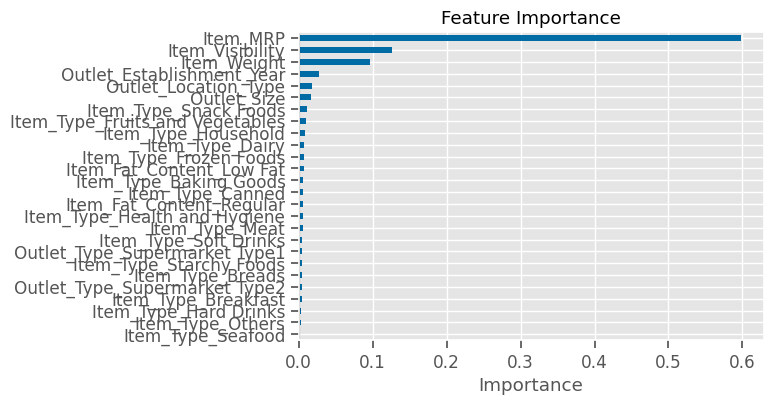

<Axes: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [39]:
evaluate_regression(rf_reg, X_train_df, y_train, x_test_df, y_test)

importances = get_importances(rf_reg)
plot_importances(importances)

In [40]:
perm_importances = pd.Series(result['importances_mean'], index=rf_reg.feature_names_in_)
perm_importances

Item_Weight                       -0.024123
Item_Visibility                   -0.008810
Item_MRP                           0.885773
Outlet_Establishment_Year          0.001784
Outlet_Size                        0.003949
Outlet_Location_Type              -0.001127
Item_Fat_Content_Low Fat          -0.001571
Item_Fat_Content_Regular          -0.001535
Item_Type_Baking Goods            -0.001152
Item_Type_Breads                  -0.002119
Item_Type_Breakfast               -0.000004
Item_Type_Canned                  -0.002714
Item_Type_Dairy                   -0.004130
Item_Type_Frozen Foods            -0.003642
Item_Type_Fruits and Vegetables   -0.003075
Item_Type_Hard Drinks             -0.000192
Item_Type_Health and Hygiene      -0.002136
Item_Type_Household               -0.000559
Item_Type_Meat                    -0.001235
Item_Type_Others                  -0.000531
Item_Type_Seafood                  0.000256
Item_Type_Snack Foods             -0.001652
Item_Type_Soft Drinks           

In [41]:
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         index=X_train.index,
                         columns=feature_names)

x_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        index=X_test.index,
                        columns=feature_names)
X_train_df.head()

X does not have valid feature names, but OrdinalEncoder was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names
X does not have valid feature names, but OrdinalEncoder was fitted with feature names
X does not have valid feature names, but OneHotEncoder was fitted with feature names


Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
512         5.695         0.065857  258.5646                     2009.0   
330        20.700         0.092613   76.3670                     1987.0   
5307       19.750         0.012438  189.9872                     1987.0   
6689        5.730         0.045557   85.3882                     2009.0   
3024       17.850         0.018052   96.6094                     1999.0   

      Outlet_Size  Outlet_Location_Type  Item_Fat_Content_Low Fat  \
512           1.0                   2.0                       1.0   
330           2.0                   2.0                       1.0   
5307          2.0                   2.0                       1.0   
6689          1.0                   2.0                       1.0   
3024          1.0                   0.0                       1.0   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  ...  \
512                        0.0                     0.0               0.0  ...   
330                        0.0                     0.0               0.0  ...   
5307                       0.0                     0.0               0.0  ...   
6689                       0.0                     0.0               0.0  ...   
3024                       0.0                     0.0               0.0  ...   

      Item_Type_Health and Hygiene  Item_Type_Household  Item_Type_Meat  \
512                            0.0                  0.0             0.0   
330                            0.0                  0.0             0.0   
5307                           0.0                  0.0             0.0   
6689                           0.0                  0.0             0.0   
3024                           1.0                  0.0             0.0   

      Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
512                0.0                0.0                    0.0   
330                0.0                0.0                    0.0   
5307               0.0                0.0                    0.0   
6689               0.0                0.0                    0.0   
3024               0.0                0.0                    0.0   

      Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
512                     0.0                      0.0   
330                     0.0                      0.0   
5307                    0.0                      0.0   
6689                    1.0                      0.0   
3024                    0.0                      0.0   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  
512                             0.0                            1.0  
330                             1.0                            0.0  
5307                            1.0                            0.0  
6689                            0.0                            1.0  
3024                            1.0                            0.0  

[5 rows x 26 columns]

In [42]:
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

In [43]:
X_shap = shap.sample(X_train_df,nsamples = 500,random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
6021        20.75             0.03    150.47                   1,999.00   
3085        15.75             0.17     36.65                   1,997.00   
1440         9.70             0.11    158.86                   1,999.00   
459         15.00             0.04    140.38                   1,987.00   
5005        10.10             0.06    117.85                   1,997.00   

      Outlet_Size  Outlet_Location_Type  Item_Fat_Content_Low Fat  \
6021         1.00                  0.00                      1.00   
3085         0.00                  0.00                      1.00   
1440         1.00                  0.00                      1.00   
459          2.00                  2.00                      1.00   
5005         0.00                  0.00                      1.00   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  ...  \
6021                      0.00                    0.00              0.00  ...   
3085                      0.00                    0.00              0.00  ...   
1440                      0.00                    0.00              0.00  ...   
459                       0.00                    0.00              0.00  ...   
5005                      0.00                    0.00              0.00  ...   

      Item_Type_Health and Hygiene  Item_Type_Household  Item_Type_Meat  \
6021                          1.00                 0.00            0.00   
3085                          0.00                 0.00            0.00   
1440                          1.00                 0.00            0.00   
459                           1.00                 0.00            0.00   
5005                          0.00                 1.00            0.00   

      Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
6021              0.00               0.00                   0.00   
3085              0.00               0.00                   0.00   
1440              0.00               0.00                   0.00   
459               0.00               0.00                   0.00   
5005              0.00               0.00                   0.00   

      Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
6021                   0.00                     0.00   
3085                   0.00                     0.00   
1440                   0.00                     0.00   
459                    0.00                     0.00   
5005                   0.00                     0.00   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  
6021                           1.00                           0.00  
3085                           1.00                           0.00  
1440                           1.00                           0.00  
459                            1.00                           0.00  
5005                           1.00                           0.00  

[5 rows x 26 columns]

In [47]:
# Instantiate a Model Explainer with the model
explainer = shap.Explainer(rf_reg)

## Get shap values from the explainer
shap_values = explainer(X_shap,y_shap)

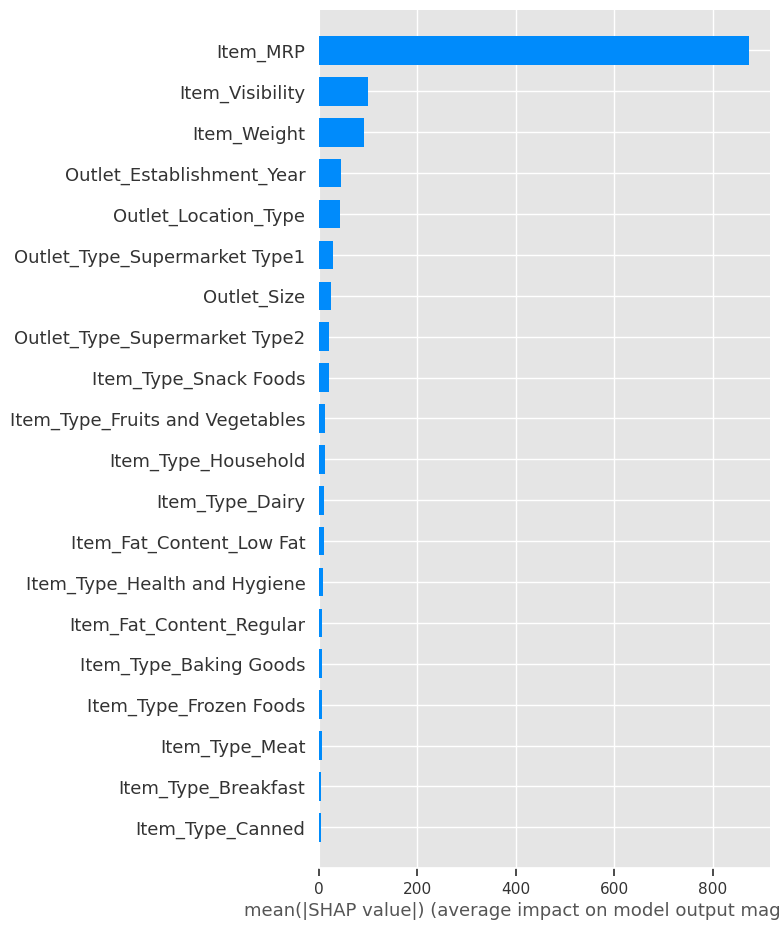

In [48]:
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')


- In comparison to the previous model, item visibility holds less sway over this model's predictive.
- capabilities. In general, the features exhibit a high degree of similarity between the two models.

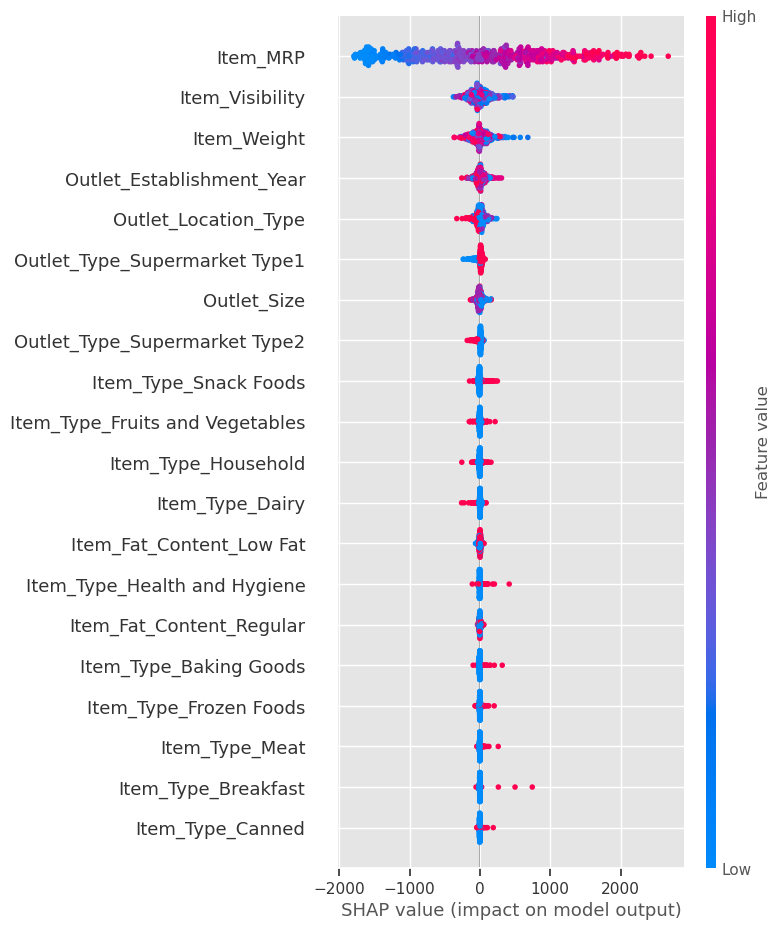

In [49]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values, features = X_shap)

- As the item's Maximum Retail Price (MRP) increases, the predicted item sales also increase.
- For most cases, low Item_Visibility has a negative effect on predictions (possibly indicating that items with low visibility tend to sell less)
-  In general, lighter items tend to have higher predicted sales, while heavier items tend to have lower predicted sales.

In [50]:
# Instantiate a Model Explainer with the model
rf_explainer = shap.Explainer(rf_reg)
rf_shap_values = rf_explainer(X_shap)

In [51]:
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
0        20.75             0.03    150.47                   1,999.00   
1        15.75             0.17     36.65                   1,997.00   
2         9.70             0.11    158.86                   1,999.00   
3        15.00             0.04    140.38                   1,987.00   
4        10.10             0.06    117.85                   1,997.00   

   Outlet_Size  Outlet_Location_Type  Item_Fat_Content_Low Fat  \
0         1.00                  0.00                      1.00   
1         0.00                  0.00                      1.00   
2         1.00                  0.00                      1.00   
3         2.00                  2.00                      1.00   
4         0.00                  0.00                      1.00   

   Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  ...  \
0                      0.00                    0.00              0.00  ...   
1                      0.00                    0.00              0.00  ...   
2                      0.00                    0.00              0.00  ...   
3                      0.00                    0.00              0.00  ...   
4                      0.00                    0.00              0.00  ...   

   Item_Type_Health and Hygiene  Item_Type_Household  Item_Type_Meat  \
0                          1.00                 0.00            0.00   
1                          0.00                 0.00            0.00   
2                          1.00                 0.00            0.00   
3                          1.00                 0.00            0.00   
4                          0.00                 1.00            0.00   

   Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
0              0.00               0.00                   0.00   
1              0.00               0.00                   0.00   
2              0.00               0.00                   0.00   
3              0.00               0.00                   0.00   
4              0.00               0.00                   0.00   

   Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
0                   0.00                     0.00   
1                   0.00                     0.00   
2                   0.00                     0.00   
3                   0.00                     0.00   
4                   0.00                     0.00   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  
0                           1.00                           0.00  
1                           1.00                           0.00  
2                           1.00                           0.00  
3                           1.00                           0.00  
4                           1.00                           0.00  

[5 rows x 26 columns]

In [54]:
idx_low_sale= y_shap_local.idxmin()
idx_low_sale# Continue from where you left off
idx_low_sale = y_shap_local.idxmin()
idx_low_sale

# Create a Lime explainer with X_shap_local for regression
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(training_data=X_shap_local.values,
                                      mode='regression',
                                      feature_names=X_shap_local.columns)

NUMBER_OF_FEATURES = 20

# Explain the instance with Lime
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_low_sale],
                                      rf_reg.predict,
                                      num_features=NUMBER_OF_FEATURES)

# Show Lime explanation in a notebook
exp.show_in_notebook()


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


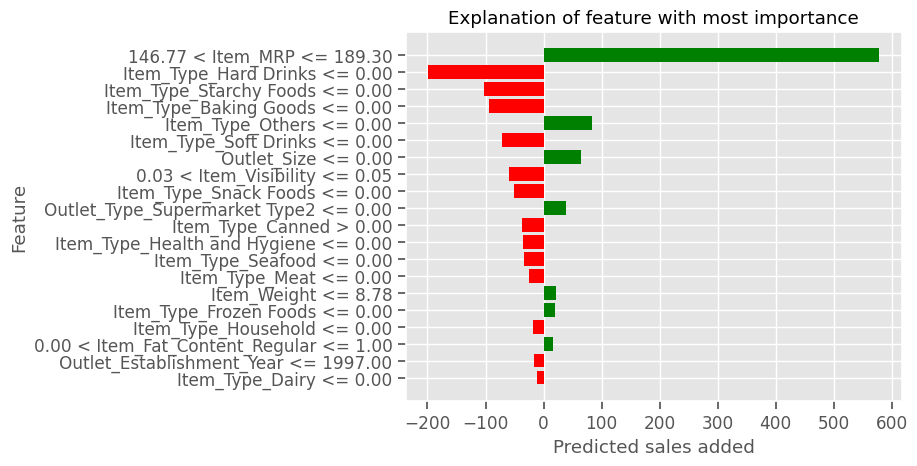

In [60]:
exp.as_pyplot_figure()
plt.title('Explanation of feature with most importance')
plt.xlabel('Predicted sales added')
plt.ylabel('Feature')
plt.savefig('low_sale_lime_explanation.png')


- The dominant factor shaping the prediction for this product is the Item MRP

In [56]:
shap.force_plot(explainer.expected_value, 
                shap_values = rf_shap_values[idx_low_sale].values,
                features=X_shap_local.iloc[idx_low_sale])

In [57]:
top_sales_index = y_shap_local.idxmax()
top_sales_index


180

In [58]:
NUMBER_OF_FEATURES=20

exp = lime_explainer.explain_instance(X_shap_local.loc[top_sales_index],
                                      rf_reg.predict, num_features=NUMBER_OF_FEATURES)
exp.show_in_notebook();

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


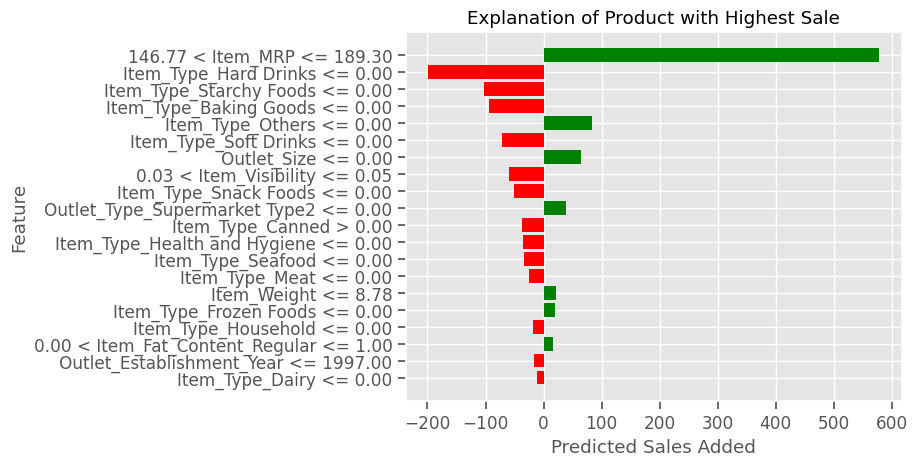

In [59]:
exp.as_pyplot_figure()
plt.title('Explanation of Product with Highest Sale')
plt.xlabel('Predicted Sales Added')
plt.ylabel('Feature')
plt.savefig('high_sale_explanation.png')

- Excluding Item MRP, the product with the highest sales value is Item_Type_Hard Drinks.

- Another significant influencer is the product's Maximum Retail Price (MRP).

In [62]:
shap.force_plot(explainer.expected_value, 
                shap_values = rf_shap_values[top_sales_index].values,
                features=X_shap_local.iloc[top_sales_index])